# Apple Test





In [1]:
import glob
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from scipy.stats import norm 
from scipy.stats import multivariate_normal
import sys

## Load data
### first part, load the training apple data and the mask,
### we use the mask to separate the data into  Real_apple_data  and  Non_apple_data

In [2]:
files = glob.glob("apples/*.jpg")
trainapple = []
for myFile in files:
    im = plt.imread(myFile)
    trainapple.append(im)
    
files = glob.glob("apples/*.png")
trainapplemask = []
for myFile in files:
    im = plt.imread(myFile)
    trainapplemask.append(im)

train_apple_pixel=[]
train_nonapple_pixel=[]
train_apple_count=0
train_nonapple_count=0

for i in range(np.size(trainapple)):
    for row in range(trainapple[i].shape[0]):        
        for col in range(trainapple[i].shape[1]):
            if trainapplemask[i][row,col,0]==1:
                train_apple_count+=1
                train_apple_pixel.append(trainapple[i][row,col,:])
            else:
                train_nonapple_count+=1
                train_nonapple_pixel.append(trainapple[i][row,col,:])



## define my own likelihood calculation function 

In [3]:
def calculatelike(data, gaussMean, gaussCov):
    '''
    data--- D by 1       (3, )
    gaussMean--- D by 1  (3, )
    gaussCov--- D by D   (3,3)
    '''
    nDim = data.shape[0]
    
    like = 1 / ((2 * np.pi) ** (nDim / 2) * np.linalg.det(gaussCov) ** 0.5) * np.exp(
        -0.5 * (data - gaussMean).T  @ np.linalg.inv(gaussCov)@ (data - gaussMean)  )
    return like



## Mostly the same as Part C, but expand to multi-dimention
### in this section, I had encounted many bugs like 'singular matrix' or 'invalid value encountered in double_scalars'. 

In [4]:
def fitMixGauss(data, k):
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    print('begin fitMixGauss')
    nDims, nData = data.shape
    postHidden = np.zeros(shape=(k, nData))

    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
        
    # calculate current likelihood
    # TO DO - fill in this routine
    nIter = 20

    for cIter in range(nIter):

        # ===================== =====================
        # Expectation step
        # ===================== =====================
        for cData in range(nData):
            # TO DO (g) : fill in column of 'hidden' - calculate posterior probability that
            # this data point came from each of the Gaussians
            # replace this:
            denominator =np.zeros(k)
            for i in range(k):
                # denominator += calculatelike(data[:,i],mixGaussEst['mean'],mixGaussEst['cov']) * mixGaussEst['weight']
                denominator[i] = calculatelike(data[:,cData],mixGaussEst['mean'][:,i],mixGaussEst['cov'][:,:,i]) * mixGaussEst['weight'][i]
            for i in range(k):
                postHidden[i,cData] = denominator[i] / np.sum(denominator[:])
                
        print('finish calculate posthidden')
        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        for cGauss in range(k):
            # TO DO (h):  Update weighting parameters mixGauss.weight based on the total
            # posterior probability associated with each Gaussian. Replace this:
            mixGaussEst['weight'][cGauss] = np.sum(postHidden[cGauss,:])/np.sum(postHidden[:,:])

            # TO DO (i):  Update mean parameters mixGauss.mean by weighted average
            # where weights are given by posterior probability associated with
            # Gaussian.  Replace this:
            mixGaussEst['mean'][:,cGauss] = postHidden[cGauss,:]@ data[:,:].T / np.sum(postHidden[cGauss,:])
            
            # TO DO (j):  Update covarance parameter based on weighted average of
            # square distance from update mean, where weights 
            # are given by
            # posterior probability associated with Gaussian
            meanvalue = mixGaussEst['mean'][:,cGauss]
            covsum=0
            covsum2=0
            for i in range(nData):
                covsum += postHidden[cGauss,i]* (data[:,i]-meanvalue)[:,np.newaxis]@(data[:,i]-meanvalue)[np.newaxis,:]
                covsum2 += postHidden[cGauss,i]
            mixGaussEst['cov'][:,:,cGauss] = covsum / covsum2

            # draw the new solution
        print('update parameter, iteration : ',cIter)

    print('return fitMixGauss')
    return mixGaussEst


## begin traing the model, here we choose k=2 for apple pixel, as there is two kinds of apple, Red and Green.
### choose k =3 for Nonapple pixel from testing

# because the start iteration point is random, the training have a certain probability of falling into a local maximum!!!  

## we have to rerun the training part for a better result

In [5]:
# training the model

train_apple_pixel=np.float32(train_apple_pixel).T/255
train_nonapple_pixel=np.float32(train_nonapple_pixel).T/255
# 必须要归一化, 不然exp太大, 无法计算

print('#######calling fitMixGauss for apppleMixGaussEst#######')
apppleMixGaussEst = fitMixGauss(train_apple_pixel,2)
print('#######calling fitMixGauss for nonapppleMixGaussEst#######')
nonapppleMixGaussEst =fitMixGauss(train_nonapple_pixel,3)

priorApple = train_apple_count/(train_apple_count+train_nonapple_count)
priorNonApple =train_nonapple_count/(train_apple_count+train_nonapple_count)


#######calling fitMixGauss for apppleMixGaussEst#######
begin fitMixGauss
finish calculate posthidden
update parameter, iteration :  0
finish calculate posthidden
update parameter, iteration :  1
finish calculate posthidden
update parameter, iteration :  2
finish calculate posthidden
update parameter, iteration :  3
finish calculate posthidden
update parameter, iteration :  4
finish calculate posthidden
update parameter, iteration :  5
finish calculate posthidden
update parameter, iteration :  6
finish calculate posthidden
update parameter, iteration :  7
finish calculate posthidden
update parameter, iteration :  8
finish calculate posthidden
update parameter, iteration :  9
finish calculate posthidden
update parameter, iteration :  10
finish calculate posthidden
update parameter, iteration :  11
finish calculate posthidden
update parameter, iteration :  12
finish calculate posthidden
update parameter, iteration :  13
finish calculate posthidden
update parameter, iteration :  14
finish

# define
### posterior calculation function
### thresholding function
### and the ROC calculation function

In [6]:
# define posterior plot funciton
# and thresholding function
# the ROC calculation function

def CalPosterior(appledata):
    '''
    return the posterior of test data
    size = (row, col)
    '''
    appledata=appledata/255
    priorSkin = priorApple
    priorNonSkin = priorNonApple
    NA_mean = nonapppleMixGaussEst['mean']
    NA_cov = nonapppleMixGaussEst['cov']
    NA_weight =nonapppleMixGaussEst['weight']
    mean  = apppleMixGaussEst['mean']
    cov = apppleMixGaussEst['cov']
    weight  = apppleMixGaussEst['weight']

    row, col, RBG = appledata.shape
    posteriorApple = np.zeros([row, col])

    for crow in range(row):
        print('Processing Row ', crow, '\n')
        for ccol in range(col):
            # extract this pixel's data
            thisPixelData = np.double(appledata[crow, ccol, :])
            likeApple=0
            likeNonApple=0
            for k in range(2):
                likeApple += weight[k]* calculatelike(thisPixelData, mean[:,k], cov[:,:,k])
                likeNonApple += NA_weight[k]* calculatelike(thisPixelData, NA_mean[:,k], NA_cov[:,:,k])
            # calculate posterior probability from weighted likelihoods
            posteriorApple[crow, ccol] = likeApple * priorSkin / (likeNonApple * priorNonSkin + likeApple * priorSkin) 
    return posteriorApple



def threshold(image, thresholdvalue):
    '''
    threshold =k /255
    '''
    nrow,ncol= image.shape 
    thresholdimage = np.zeros((nrow,ncol))
    for row in range(nrow):
        for col in range(ncol):
            if image[row,col]*255 < thresholdvalue:
                thresholdimage[row,col]=0
            else:
                thresholdimage[row,col]=1
    return thresholdimage
        


#  Function to compute the TPR and FPR and finally calculate the ROC curve

def calROC(image, mask):
    '''
    image: posterior image
    mask: binary mask

    (P, positive)
    (N, Negative)
    (TP, true positive)
    (TN, true negative)
    (FP, false positive)
    (FN, false negative)
    (TPR, true positive rate)  TPR = TP / P = TP / (TP+FN) 
    (FPR, false positive rate)  FPR = FP / N = FP / (FP + TN) 
    (ACC, accuracy)   ACC = (TP + TN) / (P + N)
    '''
    nrow,ncol=image.shape
    # TP=TN=FP=FN=TPR=FPR=np.zeros(255)
    # 不能这样定义!!!!!!!!!!!!!!!!!!!!!!!!!!!!!这样定义会是错的, 会让后面赋值的时候自动互相赋值
    TP=np.zeros(256)
    TN=np.zeros(256)
    FP=np.zeros(256)
    FN=np.zeros(256)
    TPR=np.zeros(256)
    FPR=np.zeros(256)   

    for T in range(255):
        image_T=threshold(image,T)
        print('calculating threshold=',T)
        for row in range(nrow):
            for col in range(ncol):
                if (mask[row,col,0]==1) & (image_T[row,col]==1):
                    TP[T+1]+=1
                elif (mask[row,col,0]==1) & (image_T[row,col]==0):
                    FN[T+1]+=1
                elif (mask[row,col,0]==0) & (image_T[row,col]==1):
                    FP[T+1]+=1
                else:
                    TN[T+1]+=1
        TPR[T]=TP[T]/(TP[T]+FN[T])
        FPR[T]=FP[T]/(FP[T]+TN[T])
        
    return FPR,TPR



In [7]:
# calculate the porsterior first
Posterior_trainapple1=CalPosterior(trainapple[0])
Posterior_trainapple2=CalPosterior(trainapple[1])
Posterior_trainapple3=CalPosterior(trainapple[2])

Processing Row  0 

Processing Row  1 

Processing Row  2 

Processing Row  3 

Processing Row  4 

Processing Row  5 

Processing Row  6 

Processing Row  7 

Processing Row  8 

Processing Row  9 

Processing Row  10 

Processing Row  11 

Processing Row  12 

Processing Row  13 

Processing Row  14 

Processing Row  15 

Processing Row  16 

Processing Row  17 

Processing Row  18 

Processing Row  19 

Processing Row  20 

Processing Row  21 

Processing Row  22 

Processing Row  23 

Processing Row  24 

Processing Row  25 

Processing Row  26 

Processing Row  27 

Processing Row  28 

Processing Row  29 

Processing Row  30 

Processing Row  31 

Processing Row  32 

Processing Row  33 

Processing Row  34 

Processing Row  35 

Processing Row  36 

Processing Row  37 

Processing Row  38 

Processing Row  39 

Processing Row  40 

Processing Row  41 

Processing Row  42 

Processing Row  43 

Processing Row  44 

Processing Row  45 

Processing Row  46 

Processing Row  47 

Pr

Processing Row  379 

Processing Row  380 

Processing Row  381 

Processing Row  382 

Processing Row  383 

Processing Row  384 

Processing Row  385 

Processing Row  386 

Processing Row  387 

Processing Row  388 

Processing Row  389 

Processing Row  390 

Processing Row  391 

Processing Row  392 

Processing Row  393 

Processing Row  394 

Processing Row  395 

Processing Row  396 

Processing Row  397 

Processing Row  398 

Processing Row  399 

Processing Row  400 

Processing Row  401 

Processing Row  402 

Processing Row  403 

Processing Row  404 

Processing Row  405 

Processing Row  406 

Processing Row  407 

Processing Row  408 

Processing Row  409 

Processing Row  410 

Processing Row  411 

Processing Row  412 

Processing Row  413 

Processing Row  414 

Processing Row  415 

Processing Row  416 

Processing Row  417 

Processing Row  418 

Processing Row  419 

Processing Row  420 

Processing Row  421 

Processing Row  422 

Processing Row  423 

Processing

Processing Row  267 

Processing Row  268 

Processing Row  269 

Processing Row  270 

Processing Row  271 

Processing Row  272 

Processing Row  273 

Processing Row  274 

Processing Row  275 

Processing Row  276 

Processing Row  277 

Processing Row  278 

Processing Row  279 

Processing Row  280 

Processing Row  281 

Processing Row  282 

Processing Row  283 

Processing Row  284 

Processing Row  285 

Processing Row  286 

Processing Row  287 

Processing Row  288 

Processing Row  289 

Processing Row  290 

Processing Row  291 

Processing Row  292 

Processing Row  293 

Processing Row  294 

Processing Row  295 

Processing Row  296 

Processing Row  297 

Processing Row  298 

Processing Row  299 

Processing Row  300 

Processing Row  301 

Processing Row  302 

Processing Row  303 

Processing Row  304 

Processing Row  305 

Processing Row  306 

Processing Row  307 

Processing Row  308 

Processing Row  309 

Processing Row  310 

Processing Row  311 

Processing

Processing Row  0 

Processing Row  1 

Processing Row  2 

Processing Row  3 

Processing Row  4 

Processing Row  5 

Processing Row  6 

Processing Row  7 

Processing Row  8 

Processing Row  9 

Processing Row  10 

Processing Row  11 

Processing Row  12 

Processing Row  13 

Processing Row  14 

Processing Row  15 

Processing Row  16 

Processing Row  17 

Processing Row  18 

Processing Row  19 

Processing Row  20 

Processing Row  21 

Processing Row  22 

Processing Row  23 

Processing Row  24 

Processing Row  25 

Processing Row  26 

Processing Row  27 

Processing Row  28 

Processing Row  29 

Processing Row  30 

Processing Row  31 

Processing Row  32 

Processing Row  33 

Processing Row  34 

Processing Row  35 

Processing Row  36 

Processing Row  37 

Processing Row  38 

Processing Row  39 

Processing Row  40 

Processing Row  41 

Processing Row  42 

Processing Row  43 

Processing Row  44 

Processing Row  45 

Processing Row  46 

Processing Row  47 

Pr

Processing Row  380 

Processing Row  381 

Processing Row  382 

Processing Row  383 

Processing Row  384 

Processing Row  385 

Processing Row  386 

Processing Row  387 

Processing Row  388 

Processing Row  389 

Processing Row  390 

Processing Row  391 

Processing Row  392 

Processing Row  393 

Processing Row  394 

Processing Row  395 

Processing Row  396 



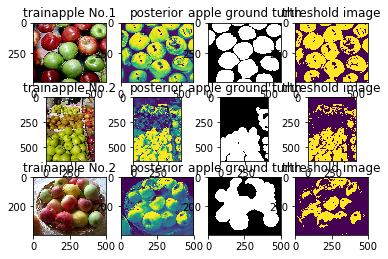

In [8]:
# plot the validation test
plt.subplot(3,4,1)
plt.title('trainapple No.1')
plt.imshow(trainapple[0])
plt.subplot(3,4,2)
plt.title('posterior')
plt.imshow(Posterior_trainapple1)
plt.subplot(3,4,3)
plt.title('apple ground turth')
plt.imshow(trainapplemask[0])
plt.subplot(3,4,4)
plt.title('threshold image')
plt.imshow(threshold(Posterior_trainapple1,160))

plt.subplot(3,4,5)
plt.title('trainapple No.2')
plt.imshow(trainapple[1])
plt.subplot(3,4,6)
plt.title('posterior')
plt.imshow(Posterior_trainapple2)
plt.subplot(3,4,7)
plt.title('apple ground turth')
plt.imshow(trainapplemask[1])
plt.subplot(3,4,8)
plt.title('threshold image')
plt.imshow(threshold(Posterior_trainapple2,160))


plt.subplot(3,4,9)
plt.title('trainapple No.2')
plt.imshow(trainapple[2])
plt.subplot(3,4,10)
plt.title('posterior')
plt.imshow(Posterior_trainapple3)
plt.subplot(3,4,11)
plt.title('apple ground turth')
plt.imshow(trainapplemask[2])
plt.subplot(3,4,12)
plt.title('threshold image')
plt.imshow(threshold(Posterior_trainapple3,160))

### the graph above is the  Origial image/ Posterior/ Ground truth/ threshold image
### for parameter training validation 

#### from the graph we can see that:  
1. trainapple1 got very good segmentation result
2. trainapple2 was not that good because the pears got similar color as Green apple
3. trainapple3 was not that good, maybe because of illumination problem


In [9]:
# load the test image
# plot the posterior of testapple

files = glob.glob("testApples/*.jpg")
testapple = []
for myFile in files:
    im = plt.imread(myFile)
    testapple.append(im)
    
files = glob.glob("testApples/*.png")
testapplemask = []
for myFile in files:
    im = plt.imread(myFile)
    testapplemask.append(im)


Posterior_testapple1=CalPosterior(testapple[0])
Posterior_testapple2=CalPosterior(testapple[1])
Posterior_testapple3=CalPosterior(testapple[2])

Processing Row  0 

Processing Row  1 

Processing Row  2 

Processing Row  3 

Processing Row  4 

Processing Row  5 

Processing Row  6 

Processing Row  7 

Processing Row  8 

Processing Row  9 

Processing Row  10 

Processing Row  11 

Processing Row  12 

Processing Row  13 

Processing Row  14 

Processing Row  15 

Processing Row  16 

Processing Row  17 

Processing Row  18 

Processing Row  19 

Processing Row  20 

Processing Row  21 

Processing Row  22 

Processing Row  23 

Processing Row  24 

Processing Row  25 

Processing Row  26 

Processing Row  27 

Processing Row  28 

Processing Row  29 

Processing Row  30 

Processing Row  31 

Processing Row  32 

Processing Row  33 

Processing Row  34 

Processing Row  35 

Processing Row  36 

Processing Row  37 

Processing Row  38 

Processing Row  39 

Processing Row  40 

Processing Row  41 

Processing Row  42 

Processing Row  43 

Processing Row  44 

Processing Row  45 

Processing Row  46 

Processing Row  47 

Pr

Processing Row  82 

Processing Row  83 

Processing Row  84 

Processing Row  85 

Processing Row  86 

Processing Row  87 

Processing Row  88 

Processing Row  89 

Processing Row  90 

Processing Row  91 

Processing Row  92 

Processing Row  93 

Processing Row  94 

Processing Row  95 

Processing Row  96 

Processing Row  97 

Processing Row  98 

Processing Row  99 

Processing Row  100 

Processing Row  101 

Processing Row  102 

Processing Row  103 

Processing Row  104 

Processing Row  105 

Processing Row  106 

Processing Row  107 

Processing Row  108 

Processing Row  109 

Processing Row  110 

Processing Row  111 

Processing Row  112 

Processing Row  113 

Processing Row  114 

Processing Row  115 

Processing Row  116 

Processing Row  117 

Processing Row  118 

Processing Row  119 

Processing Row  120 

Processing Row  121 

Processing Row  122 

Processing Row  123 

Processing Row  124 

Processing Row  125 

Processing Row  126 

Processing Row  127 

Proces

Processing Row  163 

Processing Row  164 

Processing Row  165 

Processing Row  166 

Processing Row  167 

Processing Row  168 

Processing Row  169 

Processing Row  170 

Processing Row  171 

Processing Row  172 

Processing Row  173 

Processing Row  174 

Processing Row  175 

Processing Row  176 

Processing Row  177 

Processing Row  178 

Processing Row  179 

Processing Row  180 

Processing Row  181 

Processing Row  182 

Processing Row  183 

Processing Row  184 

Processing Row  185 

Processing Row  186 

Processing Row  187 

Processing Row  188 

Processing Row  189 

Processing Row  190 

Processing Row  191 

Processing Row  192 

Processing Row  193 

Processing Row  194 

Processing Row  195 

Processing Row  196 

Processing Row  197 

Processing Row  198 

Processing Row  199 

Processing Row  200 

Processing Row  201 

Processing Row  202 

Processing Row  203 

Processing Row  204 

Processing Row  205 

Processing Row  206 

Processing Row  207 

Processing

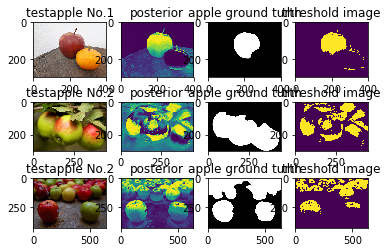

In [10]:
plt.subplot(3,4,1)
plt.title('testapple No.1')
plt.imshow(testapple[0])
plt.subplot(3,4,2)
plt.title('posterior')
plt.imshow(Posterior_testapple1)
plt.subplot(3,4,3)
plt.title('apple ground turth')
plt.imshow(testapplemask[0])
plt.subplot(3,4,4)
plt.title('threshold image')
plt.imshow(threshold(Posterior_testapple1,160))

plt.subplot(3,4,5)
plt.title('testapple No.2')
plt.imshow(testapple[1])
plt.subplot(3,4,6)
plt.title('posterior')
plt.imshow(Posterior_testapple2)
plt.subplot(3,4,7)
plt.title('apple ground turth')
plt.imshow(testapplemask[1])
plt.subplot(3,4,8)
plt.title('threshold image')
plt.imshow(threshold(Posterior_testapple2,160))


plt.subplot(3,4,9)
plt.title('testapple No.2')
plt.imshow(testapple[2])
plt.subplot(3,4,10)
plt.title('posterior')
plt.imshow(Posterior_testapple3)
plt.subplot(3,4,11)
plt.title('apple ground turth')
plt.imshow(testapplemask[2])
plt.subplot(3,4,12)
plt.title('threshold image')
plt.imshow(threshold(Posterior_testapple3,160))


### the graph above is the  Origial image/ Posterior/ Ground truth/ threshold image
### for online test image

#### from the graph we can see that:  
1. testapple1 got very good segmentation result, because the color around the apple is quite different from apple itself
2. testapple2 was not that good, we can hardly distinguished the Gradient part
3. testapple3 was not that good, maybe because of illumination problem



In [14]:
FPR,TPR = calROC(Posterior_testapple1 , testapplemask[0])


calculating threshold= 0


/Users/jasonjiang/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in double_scalars
/Users/jasonjiang/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in double_scalars


calculating threshold= 1
calculating threshold= 2
calculating threshold= 3
calculating threshold= 4
calculating threshold= 5
calculating threshold= 6
calculating threshold= 7
calculating threshold= 8
calculating threshold= 9
calculating threshold= 10
calculating threshold= 11
calculating threshold= 12
calculating threshold= 13
calculating threshold= 14
calculating threshold= 15
calculating threshold= 16
calculating threshold= 17
calculating threshold= 18
calculating threshold= 19
calculating threshold= 20
calculating threshold= 21
calculating threshold= 22
calculating threshold= 23
calculating threshold= 24
calculating threshold= 25
calculating threshold= 26
calculating threshold= 27
calculating threshold= 28
calculating threshold= 29
calculating threshold= 30
calculating threshold= 31
calculating threshold= 32
calculating threshold= 33
calculating threshold= 34
calculating threshold= 35
calculating threshold= 36
calculating threshold= 37
calculating threshold= 38
calculating threshold

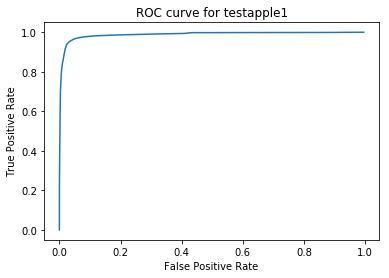

In [15]:
plt.title('ROC curve for testapple1')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(FPR,TPR)

## above is the ROC curve for online test apple, the funciton calROC is define in perious part
### because the apple in this image is very different from the background, we got very good ROC curve

In [12]:
# load the online image
# plot the posterior of online apple


files = glob.glob("online_apple/*.jpg")
online_apple = []
for myFile in files:
    im = plt.imread(myFile)
    online_apple.append(im)
    
files = glob.glob("online_apple/*.png")
online_applemask = []
for myFile in files:
    im = plt.imread(myFile)
    online_applemask.append(im)

Posterior_online_apple1=CalPosterior(online_apple[0])
Posterior_online_apple2=CalPosterior(online_apple[1])
Posterior_online_apple3=CalPosterior(online_apple[2])

Processing Row  0 

Processing Row  1 

Processing Row  2 

Processing Row  3 

Processing Row  4 

Processing Row  5 

Processing Row  6 

Processing Row  7 

Processing Row  8 

Processing Row  9 

Processing Row  10 

Processing Row  11 

Processing Row  12 

Processing Row  13 

Processing Row  14 

Processing Row  15 

Processing Row  16 

Processing Row  17 

Processing Row  18 

Processing Row  19 

Processing Row  20 

Processing Row  21 

Processing Row  22 

Processing Row  23 

Processing Row  24 

Processing Row  25 

Processing Row  26 

Processing Row  27 

Processing Row  28 

Processing Row  29 

Processing Row  30 

Processing Row  31 

Processing Row  32 

Processing Row  33 

Processing Row  34 

Processing Row  35 

Processing Row  36 

Processing Row  37 

Processing Row  38 

Processing Row  39 

Processing Row  40 

Processing Row  41 

Processing Row  42 

Processing Row  43 

Processing Row  44 

Processing Row  45 

Processing Row  46 

Processing Row  47 

Pr

Processing Row  169 

Processing Row  170 

Processing Row  171 

Processing Row  172 

Processing Row  173 

Processing Row  174 

Processing Row  175 

Processing Row  176 

Processing Row  177 

Processing Row  178 

Processing Row  179 

Processing Row  180 

Processing Row  181 

Processing Row  182 

Processing Row  183 

Processing Row  184 

Processing Row  185 

Processing Row  186 

Processing Row  187 

Processing Row  188 

Processing Row  189 

Processing Row  190 

Processing Row  0 

Processing Row  1 

Processing Row  2 

Processing Row  3 

Processing Row  4 

Processing Row  5 

Processing Row  6 

Processing Row  7 

Processing Row  8 

Processing Row  9 

Processing Row  10 

Processing Row  11 

Processing Row  12 

Processing Row  13 

Processing Row  14 

Processing Row  15 

Processing Row  16 

Processing Row  17 

Processing Row  18 

Processing Row  19 

Processing Row  20 

Processing Row  21 

Processing Row  22 

Processing Row  23 

Processing Row  24 

P

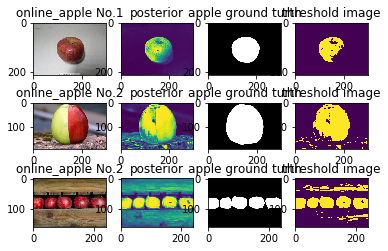

In [13]:

plt.subplot(3,4,1)
plt.title('online_apple No.1')
plt.imshow(online_apple[0])
plt.subplot(3,4,2)
plt.title('posterior')
plt.imshow(Posterior_online_apple1)
plt.subplot(3,4,3)
plt.title('apple ground turth')
plt.imshow(online_applemask[0])
plt.subplot(3,4,4)
plt.title('threshold image')
plt.imshow(threshold(Posterior_online_apple1,160))

plt.subplot(3,4,5)
plt.title('online_apple No.2')
plt.imshow(online_apple[1])
plt.subplot(3,4,6)
plt.title('posterior')
plt.imshow(Posterior_online_apple2)
plt.subplot(3,4,7)
plt.title('apple ground turth')
plt.imshow(online_applemask[1])
plt.subplot(3,4,8)
plt.title('threshold image')
plt.imshow(threshold(Posterior_online_apple2,160))


plt.subplot(3,4,9)
plt.title('online_apple No.2')
plt.imshow(online_apple[2])
plt.subplot(3,4,10)
plt.title('posterior')
plt.imshow(Posterior_online_apple3)
plt.subplot(3,4,11)
plt.title('apple ground turth')
plt.imshow(online_applemask[2])
plt.subplot(3,4,12)
plt.title('threshold image')
plt.imshow(threshold(Posterior_online_apple3,160))

## plot the posterior of online apple, and choose threshold to be 160
the rusult is pretty good, except the apple3, we can optimize the result by choosing a bigger threshold value or using greater K,  but it will be more time consuming

# We should really be using three separate sets of files: a training set, a validation set, and a test set! Explain why.

## because we have to train the data frist using our training set with mask
## validation set is to test whether our training result fits the training data

# test set is to confirm the training result (Result may only be suitable for training set)



# Extra Credit: 
### we can manipulate the photographs’ colors to improve the classification by using the HSV color space
convert the RGB channel to HSV by simply doing dot product for channel Red, Green and Blue:
      
    [Y,U,V].T =  np.array([[0.299, 0.587, 0.114],   @ [R,B,B].T
                           [-0.169, -0.332, 0.500],      
                           [0.500, -0.419, -0.081]])
   
   
then use the HSV color image retrain our models, the classification can be improved